## Wiki Project

This project will be working with a diabetic dataset to evaluate predicting/explaining factors for diabetic patients' readmissions. A journal article related to this dataset is also attached to give the background about this dataset. For additional information about this dataset, see:

https://archive.ics.uci.edu/ml/datasets/diabetes+130-us+hospitals+for+years+1999-2008


1. Preprocess your data.
    1. Handle missing variables*
    1. Code your categorical (e.g., using the get_dummies() or bag of words)*
    1. Bin your numerical variables*
    1. Conduct correlation analysis*
    1. Combine variables
    1. Apply data reduction techniques for numerical variables (e.g., PCA, SVD)
    1. Balance your classes

In [1]:
import warnings
# Load/Review/Visualize
from zipfile import ZipFile
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_profiling
# for K-Mean
from sklearn.cluster import KMeans
from pandas.plotting import parallel_coordinates
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
# Model/Prediction
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
import statsmodels.api as sm 
from keras_visualizer import visualizer 
from keras.models import Sequential
from keras.layers import Dense

# DMBA Imports
from dmba import regressionSummary, exhaustive_search
from dmba import backward_elimination, forward_selection, stepwise_selection
from dmba import adjusted_r2_score, AIC_score, BIC_score
from dmba import plotDecisionTree, classificationSummary, regressionSummary, gainsChart, liftChart

In [2]:
# Inputs
datafile="dataset_diabetes.zip"

In [3]:
mapping=[]
diabetic=[]

with ZipFile(datafile) as rawData:
        for info in rawData.infolist():
            print("Reading: ", info.filename)
            with rawData.open(info.filename) as f:
                if 'IDs_mapping' in info.filename:
                    mapping = pd.read_csv(f)
                else:
                    diabetic = pd.read_csv(f)

# Removing Colums with too many unknow values or lack of relevance based on description
dropped_Cols=['weight', 'medical_specialty', 'payer_code', 'encounter_id', 'patient_nbr']
diabetic.drop(columns=dropped_Cols, inplace=True)
# Drop remaining rows with unknown values
diabetic.drop(index=(diabetic[diabetic.isin(['?']).any(axis=1)].index), inplace=True)
# Let's check what's left
diabetic.shape
diabetic.head(20)

#diabetic = pd.get_dummies(diabetic, prefix_sep='_', drop_first=False)



Reading:  dataset_diabetes/diabetic_data.csv
Reading:  dataset_diabetes/IDs_mapping.csv


,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
1,Caucasian,Female,[10-20),1,1,7,3,59,0,18,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,AfricanAmerican,Female,[20-30),1,1,7,2,11,5,13,...,No,No,No,No,No,No,No,No,Yes,NO
3,Caucasian,Male,[30-40),1,1,7,2,44,1,16,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,Caucasian,Male,[40-50),1,1,7,1,51,0,8,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
5,Caucasian,Male,[50-60),2,1,2,3,31,6,16,...,No,Steady,No,No,No,No,No,No,Yes,>30
6,Caucasian,Male,[60-70),3,1,2,4,70,1,21,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
7,Caucasian,Male,[70-80),1,1,7,5,73,0,12,...,No,No,No,No,No,No,No,No,Yes,>30
8,Caucasian,Female,[80-90),2,1,4,13,68,2,28,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
9,Caucasian,Female,[90-100),3,3,4,12,33,3,18,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
10,AfricanAmerican,Female,[40-50),1,1,7,9,47,2,17,...,No,Steady,No,No,No,No,No,No,Yes,>30


In [4]:
# The profile is completely optionional and not required to run the models
# It was used to review the dataset.
profile1 = pandas_profiling.ProfileReport(diabetic)

In [5]:
profile1.to_file('profile1.html')

Summarize dataset:   0%|          | 0/59 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
profile1.to_widgets()

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

## Profiling results

Based the profile results, we can make additional cleanup steps:


## Categorical Data

### Gender

We normalize this feature by creating a single "isFemale" binary feature and we remove the one patient of unknown gender. We can than drop the gender.

In [7]:
diabetic["isFemale"] = False
diabetic.loc[diabetic.gender == "Female", "isFemale"] = True
diabetic = diabetic[diabetic.gender != "Unknown/Invalid"]
diabetic.drop(columns=['gender'], inplace=True)

### Race

With race, I will simply create categorical binary features, and we can drop the gender.


In [8]:
diabetic = pd.get_dummies(data = diabetic, columns = ["race"], prefix = "race", drop_first=False)

### Diagnostic

There are three independant diagnostics and each can be over 700 different values. For this purpose, I will simplify the diagnostic into a few relevant categories.

A few of the diagnostics start with E and with V. Those will be other. For numeric icd9 codes, I followed information from the paper going with the data:

> The following abbreviations are used for particular icd9 codes: “circulatory” for icd9: 390–459, 785, “digestive” for icd9: 520–579, 787, “genitourinary” for icd9: 580–629, 788, “diabetes” for icd9: 250.xx, “injury” for icd9: 800–999, “musculoskeletal” for icd9: 710–739, “neoplasms” for icd9: 140–239, “respiratory’’ for icd9: 460–519, 786, and “other” for otherwise.

From: https://www.hindawi.com/journals/bmri/2014/781670/#results-and-discussion


In [9]:
def fix_diag(diabetic, icd9) :
    if diabetic[icd9][0] == "E" :
        return "Other"
    elif diabetic[icd9][0] == "V" :
        return "Other"
    else :
        num = float(diabetic[icd9])
        
        if np.trunc(num) == 250 :
            return "diabetes"
        elif num <= 139 :
            return "other"
        elif num <= 279 :
            return "neoplasms"
        elif num <= 389 :
            return "other"
        elif num <= 459 :
            return "circulatory"
        elif num <= 519 :
            return "respiratory"
        elif num <= 579 :
            return "digestive"
        elif num <= 629 :
            return "genitourinary"
        elif num <= 679 :
            return "other"
        elif num <= 709 :
            return "neoplasms"
        elif num <= 739 :
            return "musculoskeletal"
        elif num <= 759 :
            return "other"
        elif num in [780, 781, 782, 783, 784] : 
            return "neoplasms"
        elif num == 785 :
            return "circulatory"
        elif num == 786 :
            return "respiratory"
        elif num == 787 :
            return "digestive"
        elif num == 788 :
            return "genitourinary"
        elif num == 789 :
            return "digestive"
        elif num in np.arange(790, 800) :
            return "neoplasms"
        elif num >= 800 :
            return "injury"
        else :
            return num

diabetic["diag1_norm"] = diabetic.apply(fix_diag, axis=1, icd9="diag_1")
diabetic["diag2_norm"] = diabetic.apply(fix_diag, axis=1, icd9="diag_2")
diabetic["diag3_norm"] = diabetic.apply(fix_diag, axis=1, icd9="diag_3")

Armed with a "textual" diagnosis instead of a code, we can now create binary variables, once for each diagnosis.
- diabetes_diagnosis
- other_diagnosis
- etc.

In [10]:
def diagnose (diabetic, diag) :
    if (diabetic["diag1_norm"] == diag) | (diabetic["diag2_norm"] == diag) | (diabetic["diag3_norm"] == diag) :
        return True
    else :
        return False

for val in ['diabetes', 'other', 'circulatory', 'neoplasms', 'respiratory', 'injury', 'musculoskeletal', 'digestive', 'genitourinary'] :
    name = val + "_diagnosis"
    diabetic[name] = diabetic.apply(diagnose, axis = 1, diag=val)

dropped_Cols=['diag1_norm', 'diag2_norm', 'diag3_norm', 'diag_1', 'diag_2', 'diag_3']
diabetic.drop(columns=dropped_Cols, inplace=True)


### Drugs

- We'll remove drugs rarely present like `examide`, `citoglipton` and `metformin-rosiglitazone`
- For other "common" drugs found more often, we can create a binary variable where No is FALSE and Down, Steady or Up means the drug was "present" so TRUE.

In [11]:
common_drugs = ['metformin', 'repaglinide', 'glimepiride', 'glipizide',
                'glyburide', 'pioglitazone', 'rosiglitazone', 'insulin']
rare_drugs = ["nateglinide", "chlorpropamide", "acetohexamide", "tolbutamide",
             "acarbose", "miglitol", "troglitazone", "tolazamide", "examide",
             "citoglipton", "glyburide-metformin", "glipizide-metformin",
             "glimepiride-pioglitazone", "metformin-rosiglitazone", "metformin-pioglitazone"]

drugs = common_drugs + rare_drugs

In [12]:
for drug in common_drugs :
    name = "take_" + drug
    diabetic[name] = diabetic[drug].isin(["Down", "Steady", "Up"])

In [13]:
diabetic.drop(columns=drugs, inplace=True)

### Readmissions (our outcome)

The current variable `readmitted` is `NO`, `>30` if readmitted after 30 days, or `<30` if readmitted under 30 days.
I will create a single dummy "readmitted" which means the patient was readmitted under 30 days, the outcome we are looking to predict.

In [14]:
diabetic = pd.get_dummies(data = diabetic, columns = ["readmitted"], prefix = "readmit", drop_first=False)
# I didn't use drop_first to be sure I was dropping readmit_NO
diabetic = diabetic.drop(["readmit_NO"], axis = 1)

After consideration, I will drop readmit_>30 and entirely focus on patients readmitted under 30 days for this study.

In [15]:
diabetic = diabetic.drop(["readmit_>30"], axis = 1)
diabetic.rename(columns = {'readmit_<30': 'readmitted'}, inplace = True)

### A1C and GluSerum tests

According to the paper, `A1C` of `>7` or `>8` would be considered abnormal. Same for `>200` or `>300` for the GluSerum test. I will combine these two to reduce the number of categorical variables. 

In [16]:
diabetic["A1C"] = diabetic["A1Cresult"]
diabetic.loc[diabetic.A1Cresult.isin([">7", ">8"]), "A1C"] = "Abnorm"

diabetic = pd.get_dummies(data = diabetic, columns = ["A1C"], prefix = "A1C", drop_first=False)
diabetic = diabetic.drop(["A1Cresult", "A1C_None"], axis = 1)

In [17]:
diabetic["glu_serum"] = diabetic["max_glu_serum"]
diabetic.loc[diabetic.max_glu_serum.isin([">200", ">300"]), "glu_serum"] = "Abnorm"

diabetic = pd.get_dummies(data = diabetic, columns = ["glu_serum"], prefix = "glu_serum", drop_first=False)
diabetic = diabetic.drop(["max_glu_serum", "glu_serum_None"], axis = 1)

### Change and diabetesMed

These two features simply need to converted:
- for `Change`, from `Ch` to `True` and `No` to `False`
- for `diabetesMed`, from `Yes` to `True` and `No` to `False`.

In [18]:
diabetic.loc[diabetic.change == "Ch", "change"] = True
diabetic.loc[diabetic.change == "No", "change"] = False

diabetic.loc[diabetic.diabetesMed == "Yes", "diabetesMed"] = True
diabetic.loc[diabetic.diabetesMed == "No", "diabetesMed"] = False

## Unmapped Data

After, I elected to remove columns I was not clear would yield useful information for this model
- admission_type_id
- discharge_disposition_id	
- admission_source_id

I could no easily find a mapping for these IDs and give the information meaning.

In [19]:
diabetic.drop(columns=['admission_type_id', 'discharge_disposition_id', 'admission_source_id'], inplace=True)

## Quantitative Variables

### Age

Age should be quantitative, we will return it to a numerical value by simply taking the first digit for the decade:
- 10-20 == 10
- 20-30 == 20
etc.

In [20]:
def cutage (df) :
    return int(df.age[-4::].replace('-', '').replace(')', ''))

diabetic["decade"] = diabetic.apply(cutage, axis = 1)
#var_quanti.append("age_num")
diabetic = diabetic.drop("age", axis = 1)

In [21]:
quant_values = ['decade', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 
                'num_medications', 'number_outpatient', 'number_emergency', 
                'number_inpatient','number_diagnoses' ]

In [22]:
diabetic

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,change,diabetesMed,...,take_glyburide,take_pioglitazone,take_rosiglitazone,take_insulin,readmitted,A1C_Abnorm,A1C_Norm,glu_serum_Abnorm,glu_serum_Norm,decade
1,3,59,0,18,0,0,0,9,True,True,...,False,False,False,True,0,0,0,0,0,20
2,2,11,5,13,2,0,1,6,False,True,...,False,False,False,False,0,0,0,0,0,30
3,2,44,1,16,0,0,0,7,True,True,...,False,False,False,True,0,0,0,0,0,40
4,1,51,0,8,0,0,0,5,True,True,...,False,False,False,True,0,0,0,0,0,50
5,3,31,6,16,0,0,0,9,False,True,...,False,False,False,True,0,0,0,0,0,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,3,51,0,16,0,0,0,9,True,True,...,False,False,False,True,0,1,0,0,0,80
101762,5,33,3,18,0,0,1,9,False,True,...,False,False,False,True,0,0,0,0,0,90
101763,1,53,0,9,1,0,0,13,True,True,...,False,False,False,True,0,0,0,0,0,80
101764,10,45,2,21,0,0,1,9,True,True,...,False,True,False,True,0,0,0,0,0,90


## Re-profiling for a quick verification


In [23]:
# The profile is completely optionional and not required to run the models
# It was used to review the dataset.
profile2 = pandas_profiling.ProfileReport(diabetic)
profile2.to_file('profile2.html')

Summarize dataset:   0%|          | 0/53 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
profile2.to_widgets()

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

## Correlations

Reviewing correlations is a useful exercise. Some of this was done twice already, using the pandas-profiling function. Clear correlation maps were produced, before AND after the data was cleaned up and organized.

Following the organization, we have dropped the number of warnings to only 6 obvious ones. And the correlation maps makes more sense (see below).

We have definite stronger correlations between: time_in_hospital, num_lab_procedures, num_procedures and number of medications. This cluster of correlations makes sense.

From a "readmission" perspective, we do notice some correlations with the num_emergency and num_inpatiet, also expected.


<AxesSubplot:>

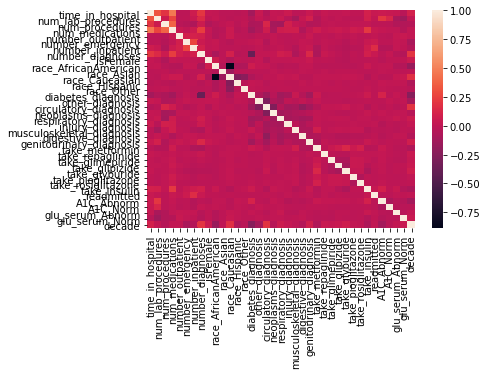

In [25]:
corr = diabetic.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)

# 2. Visualize your dataset.

We will consider the following visualization technique:
- Basic charts (e.g., bar, line, ad scatter plots)*
- Heatmaps*
- Multidimensional visualization
- Network
- Treemaps

## Quant Data

First, let quickly vizualize the quantitative data:

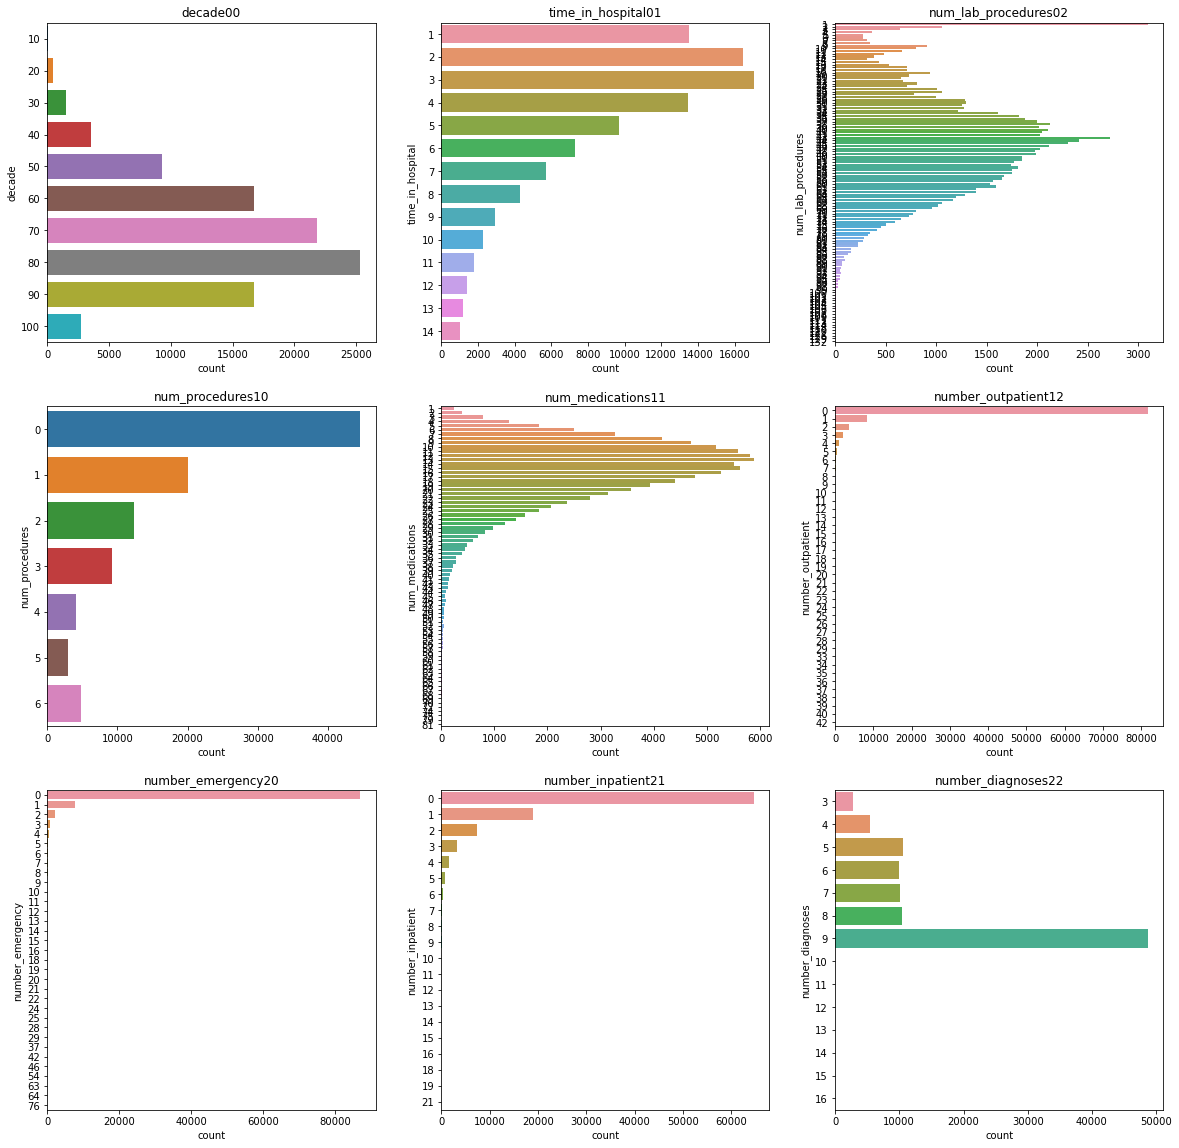

In [26]:
# We will be using the list of quant_values
# We need to count how many rows we need
rowsTot = -(-(len(quant_values)) // 3)

# Where we start
rowNum=0
colNum=0
fig, axs = plt.subplots(rowsTot, 3, figsize = (20, 20))

for feature in quant_values:
    sns.countplot(data = diabetic, y = feature, ax = axs[rowNum, colNum])
    axs[rowNum, colNum].set_title(feature + str(rowNum) + str(colNum))
    # Col numbers flips between 1 and 2, Rows increase by one
    if colNum < 2: 
        colNum += 1
    else:
        colNum = 0
        rowNum += 1

plt.show()

### Distribution of all readmission

Next we look at the distribution of our outcome, patients readmitted under 30 days.

Text(0.5, 1.0, 'Distribution of Readmission')

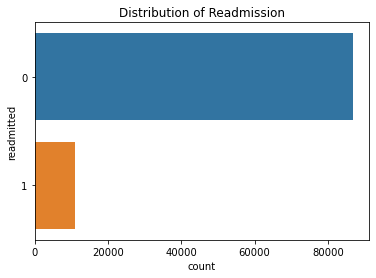

In [27]:
sns.countplot(data = diabetic, y = 'readmitted').set_title('Distribution of Readmission')

### Time in Hospital

We can look at some of our features and compare them for the patients readmitted, versus those not. In this case, we look at time in hospital.

Text(0.5, 1.0, 'Time in Hospital compared to readmission')

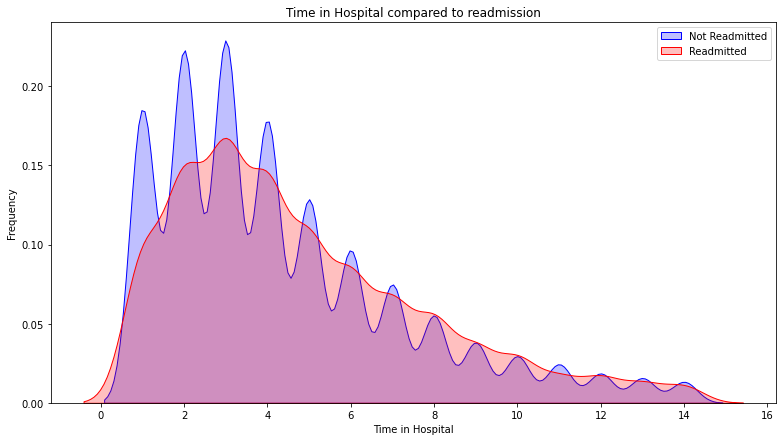

In [28]:
fig = plt.figure(figsize=(13,7),)
ax=sns.kdeplot(diabetic.loc[(diabetic['readmitted'] == 0),'time_in_hospital'] , color='b',shade=True,label='Not Readmitted')
ax=sns.kdeplot(diabetic.loc[(diabetic['readmitted'] == 1),'time_in_hospital'] , color='r',shade=True, label='Readmitted')
ax.set(xlabel='Time in Hospital', ylabel='Frequency')
plt.legend()
plt.title('Time in Hospital compared to readmission')

# 3. K-mean

Next we look to apply clustering algorithms:
- first apply K-mean to evaluate the clusters
- next apply at least one of the hierarchical clustering

## Cluster Sizes

First we evaluate different cluster sizes to see how we want to cluster the data.

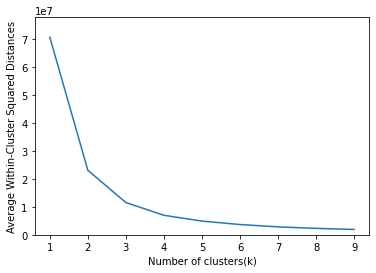

In [29]:
# k-means clustering
inertia = []
for n_clusters in range(1, 10):
    kmeans = KMeans(n_clusters=n_clusters, random_state=1).fit(diabetic)
    inertia.append(kmeans.inertia_ / n_clusters)
inertias = pd.DataFrame({'n_clusters': range(1, 10), 'inertia': inertia})
ax = inertias.plot(x='n_clusters', y='inertia')
plt.xlabel('Number of clusters(k)')
plt.ylabel('Average Within-Cluster Squared Distances')
plt.ylim((0, 1.1 * inertias.inertia.max()))
ax.legend().set_visible(False)
plt.show()

From reviewing the plot above, we can see that anything 4 clusters and above will have similar results. So we stick with `n=4` for the next steps.

In [30]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(diabetic)

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,change,diabetesMed,...,take_pioglitazone,take_rosiglitazone,take_insulin,readmitted,A1C_Abnorm,A1C_Norm,glu_serum_Abnorm,glu_serum_Norm,decade,cluster
0,6.058254,65.792252,1.614653,20.305242,0.431758,0.169009,0.666694,8.145073,0.514991,0.799258,...,0.073433,0.064092,0.595847,0.123097,0.181352,0.083316,0.016805,0.008965,76.819148,Cluster 1
1,3.271962,12.222082,1.278891,13.482763,0.460772,0.203299,0.522735,7.274482,0.428416,0.760451,...,0.077712,0.066716,0.477036,0.100905,0.026286,0.012198,0.077483,0.094147,71.169969,Cluster 2
2,3.961168,46.098162,1.300627,15.242401,0.308844,0.327531,0.755611,6.967662,0.480253,0.769747,...,0.064101,0.060523,0.578327,0.105407,0.170613,0.058137,0.017450,0.008835,51.368616,Cluster 3
3,4.165190,41.095252,1.234686,15.104789,0.338916,0.142319,0.624231,7.550172,0.429047,0.750007,...,0.074412,0.061637,0.482736,0.116740,0.078562,0.039060,0.015453,0.013923,80.636388,Cluster 4


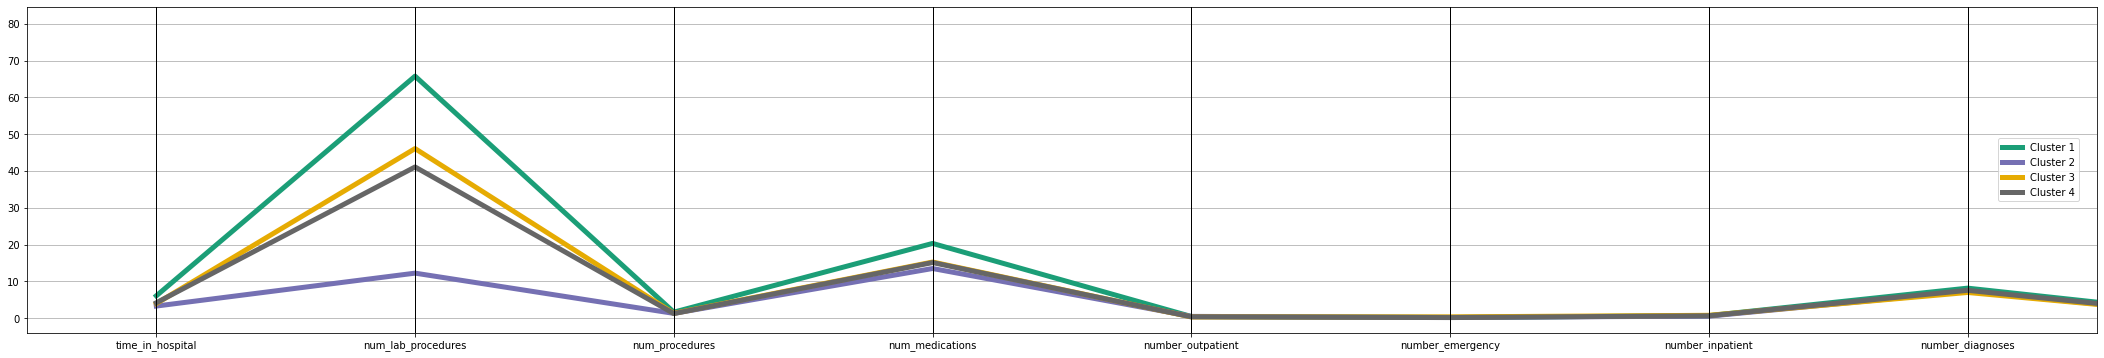

In [31]:
#Plot of centroid
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=diabetic.columns)
centroids['cluster'] = ['Cluster {}'.format(i+1) for i in centroids.index]

fig = plt.figure(figsize=(10,6))
fig.subplots_adjust(right=3)
ax = parallel_coordinates(centroids, class_column='cluster', colormap='Dark2', linewidth=5)
plt.legend(loc='center left', bbox_to_anchor=(0.95, 0.5))
plt.xlim(-0.5,7.5)
centroids

### Hiarchical Clustering

From here we start linking clusters, starting from 4.

In [ ]:
Z = linkage(diabetic, method='average')

fig = plt.figure(figsize=(10, 6))
fig.subplots_adjust(bottom=0.23)
plt.title('Hierarchical Clustering Dendrogram (Average linkage)')
plt.xlabel('Patients')
dendrogram(Z, labels=list(diabetic.index), color_threshold=3.9)
plt.axhline(y=3.6, color='black', linewidth=0.5, linestyle='dashed')
plt.show()

In [ ]:
memb = fcluster(linkage(diabetic, 'average'), 4, criterion='maxclust')
memb = pd.Series(memb, index=diabetic.index)
#for key, item in memb.groupby(memb):
#    print(key, ': ', ', '.join(item.index))

In [ ]:
diabetic.index = ['{}: {}'.format(cluster, state) for cluster, state in zip(memb, diabetic.index)]
sns.clustermap(diabetic, method='ward', col_cluster=False,  cmap="mako_r")
plt.show()

# 4. Predict

Predict the outcome of interest following standard steps. We have a discrete outcome variable (Readmitted Yes/No) so we use the following steps:
- Partition your data into 60% training and 40% validation. Use seed = 1.*
- Create models and run prediction using the following methods:
    - Logistic regression (with at least one variable selection or shrinkage technique).
    - Classification trees
    - Artificial neural networks (e.g., ANN, CNN, or RNN)
    
### SkLearn Logistic Regression

In [32]:
# We first partition our data and prepare our input variables
X = diabetic.drop(['readmitted'],axis=1)
y = diabetic["readmitted"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)

Armed with our input variables, we can run our logistic regression model, us it to run predictions on our data and review the accuracy of our model.

In [33]:
logit = LogisticRegression(fit_intercept=True, penalty='l2', max_iter=1000)
logit.fit(X_train, y_train)
logit_pred = logit.predict(X_test)
pd.crosstab(pd.Series(y_test, name = 'Actual'), pd.Series(logit_pred, name = 'Predict'), margins = True)
print("Accuracy is {0:.2f}".format(accuracy_score(y_test, logit_pred)))
print("Precision is {0:.2f}".format(precision_score(y_test, logit_pred)))
print("Recall is {0:.2f}".format(recall_score(y_test, logit_pred)))

accuracy_logit = accuracy_score(y_test, logit_pred)
precision_logit = precision_score(y_test, logit_pred)
recall_logit = recall_score(y_test, logit_pred)
summary_logit = classificationSummary(y_test, logit.predict(X_test))

logit_proba = logit.predict_proba(X_test)
logit_result = pd.DataFrame({'actual': y_test, 
                                'p(0)': [p[0] for p in logit_proba],
                                'p(1)': [p[1] for p in logit_proba],
                                'predicted': logit.predict(X_test),
                               })
logit_result = logit_result.sort_values(by=['p(1)'], ascending=False)

Accuracy is 0.88
Precision is 0.45
Recall is 0.01
Confusion Matrix (Accuracy 0.8844)

       Prediction
Actual     0     1
     0 34627    75
     1  4457    62


### StatsModel Logistic Regression, with variable selection

As a second test, I will build a LogisticRegression model, using an approach discovered online. We are going to create a model with all variables, and then remove the variable with the highest p-value. By iterations, we are goind to remove all non-relevant features, until all of our variables have a p-value < 0.05. Function below automates this process.

In [34]:
def reduction_variable_logit(X_train, y_train, showVarToDel=False) :
    final_model = False
    var_to_del = []

    while (final_model == False) :
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            log_reg = sm.Logit(y_train, 
                               X_train.drop(var_to_del, axis = 1).astype(float)).fit(maxiter = 100, disp = False)
        max_pvalue = max(log_reg.pvalues)
        if max_pvalue < 0.05 :
            final_model = True
        else :
            varToDel = log_reg.pvalues.index[log_reg.pvalues == max(log_reg.pvalues)].values[0]
            if showVarToDel :
                print(varToDel + ", p-value = " + str(max(log_reg.pvalues)))
            var_to_del.append(varToDel)
    
    return log_reg, var_to_del

log_reg, var_to_del = reduction_variable_logit(X_train, y_train, False)

In [35]:
var_to_del

['isFemale',
 'take_repaglinide',
 'injury_diagnosis',
 'take_insulin',
 'num_lab_procedures',
 'glu_serum_Norm',
 'other_diagnosis',
 'take_glyburide',
 'number_outpatient',
 'genitourinary_diagnosis',
 'musculoskeletal_diagnosis',
 'take_glipizide',
 'take_pioglitazone',
 'take_glimepiride',
 'A1C_Norm',
 'glu_serum_Abnorm',
 'change',
 'take_rosiglitazone',
 'circulatory_diagnosis',
 'digestive_diagnosis',
 'neoplasms_diagnosis']

We finalize by re-running the SKLearn approach with the reduced variable scope as a verificaton that we've improved the model. This is not really a valid step in any ML analysis workflow but I use it to verify my work and my process.

In [36]:
newlogit = LogisticRegression(fit_intercept=True, penalty='l2', max_iter=1000)
newlogit.fit(X_train.drop(var_to_del, axis = 1), y_train)
newlogit_pred = newlogit.predict(X_test.drop(var_to_del, axis = 1))
pd.crosstab(pd.Series(y_test, name = 'Actual'), pd.Series(newlogit_pred, name = 'Predict'), margins = True)
print("Accuracy is {0:.2f}".format(accuracy_score(y_test, newlogit_pred)))
print("Precision is {0:.2f}".format(precision_score(y_test, newlogit_pred)))
print("Recall is {0:.2f}".format(recall_score(y_test, newlogit_pred)))

accuracy_newlogit = accuracy_score(y_test, newlogit_pred)
precision_newlogit = precision_score(y_test, newlogit_pred)
recall_newlogit = recall_score(y_test, newlogit_pred)

newlogit_proba = newlogit.predict_proba(X_test.drop(var_to_del, axis = 1))
newlogit_result = pd.DataFrame({'actual': y_test, 
                                'p(0)': [p[0] for p in newlogit_proba],
                                'p(1)': [p[1] for p in newlogit_proba],
                                'predicted': newlogit.predict(X_test.drop(var_to_del, axis = 1)),
                               })
newlogit_result = newlogit_result.sort_values(by=['p(1)'], ascending=False)

Accuracy is 0.88
Precision is 0.47
Recall is 0.01


### Classification Tree

As specific, we then build and test a *Classification Tree* model and compare results.

In [37]:
#full tree
fullClassTree = DecisionTreeClassifier(max_depth=28, criterion = "entropy", min_samples_split=10)
fullClassTree.fit(X_train, y_train)

fullClassTree_pred = fullClassTree.predict(X_test)
pd.crosstab(pd.Series(y_test, name = 'Actual'), pd.Series(fullClassTree_pred, name = 'Predict'), margins = True)

print("Accuracy is {0:.2f}".format(accuracy_score(y_test, fullClassTree_pred)))
print("Precision is {0:.2f}".format(precision_score(y_test, fullClassTree_pred)))
print("Recall is {0:.2f}".format(recall_score(y_test, fullClassTree_pred)))

accuracy_fulltree = accuracy_score(y_test, fullClassTree_pred)
precision_fulltree = precision_score(y_test, fullClassTree_pred)
recall_fulltree = recall_score(y_test, fullClassTree_pred)

fullClassTree_proba = fullClassTree.predict_proba(X_test)
fullClassTree_result = pd.DataFrame({'actual': y_test, 
                                'p(0)': [p[0] for p in fullClassTree_proba],
                                'p(1)': [p[1] for p in fullClassTree_proba],
                                'predicted': fullClassTree.predict(X_test),
                               })
fullClassTree_result = fullClassTree_result.sort_values(by=['p(1)'], ascending=False)

Accuracy is 0.82
Precision is 0.14
Recall is 0.11


### ANN

Our third model will use artificial neural networks.

In [38]:
# create model
annmodel = Sequential()
annmodel.add(Dense(12, input_dim=38, activation='relu'))
annmodel.add(Dense(8, activation='relu'))
annmodel.add(Dense(1, activation='sigmoid'))

In [39]:
# Compile model
annmodel.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [40]:
#print model summary
print('Neural Network Model Summary: ')
print(annmodel.summary())

Neural Network Model Summary: 
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12)                468       
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 104       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 581
Trainable params: 581
Non-trainable params: 0
_________________________________________________________________
None


In [41]:
# Fix int to np.int so they fit in Tensor
X_ann=np.asarray(X).astype(np.int)
y_ann=np.asarray(y).astype(np.int)
X_train_ann=np.asarray(X_test).astype(np.int)
y_train_ann=np.asarray(y_test).astype(np.int)
X_test_ann=np.asarray(X_test).astype(np.int)
y_test_ann=np.asarray(y_test).astype(np.int)

In [42]:
# Fit the model; set verbose to 1 or 2 to see the training metrics in each epoch
history = annmodel.fit(X_ann, y_ann, validation_split=0.40, epochs=100, batch_size=2000, verbose=0)

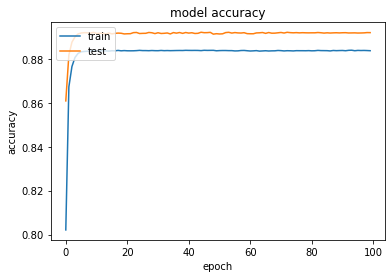

In [43]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

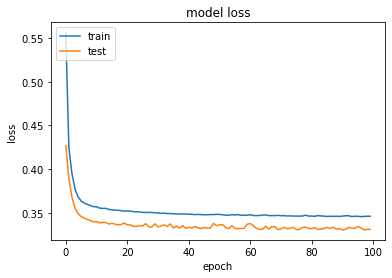

In [44]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# 5. Performance Review

Next we judge the performance of various supervised techniques that we applied to the dataset. We look to:
- Print the confusion matrix and the accuracy rate for each technique
- Plot Gains and Lift charts for binary data
- Plot the ROC (combine all measures in one graph)

### Confusion Matrix and the Accuracy Rate 

In [45]:
print("Confusion Matrix and acccuracy for Logistic Regression:")
classificationSummary(logit_result.actual, logit_result.predicted)

print("-----------------------------------------------------------")
print("Confusion Matrix and acccuracy for LogReg reduced:")
classificationSummary(newlogit_result.actual, newlogit_result.predicted)
print("")
print("-----------------------------------------------------------")
print("Confusion Matrix and acccuracy for LogReg reduced:")
classificationSummary(fullClassTree_result.actual, fullClassTree_result.predicted)
print("")
print("-----------------------------------------------------------")
print("Acccuracy for ANN model:")

history.history['val_accuracy'][-1]

Confusion Matrix and acccuracy for Logistic Regression:
Confusion Matrix (Accuracy 0.8844)

       Prediction
Actual     0     1
     0 34627    75
     1  4457    62
-----------------------------------------------------------
Confusion Matrix and acccuracy for LogReg reduced:
Confusion Matrix (Accuracy 0.8846)

       Prediction
Actual     0     1
     0 34631    71
     1  4457    62

-----------------------------------------------------------
Confusion Matrix and acccuracy for LogReg reduced:
Confusion Matrix (Accuracy 0.8227)

       Prediction
Actual     0     1
     0 31781  2921
     1  4031   488

-----------------------------------------------------------
Acccuracy for ANN model:


0.8918691277503967

### Gains and Lift charts

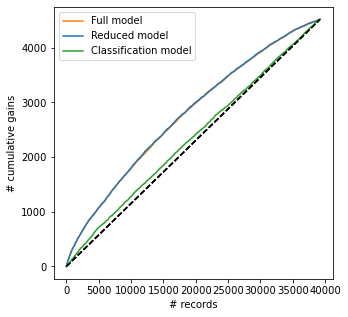

In [46]:
ax = gainsChart(logit_result.actual, label='Full model', color='C1', figsize=[5, 5])
ax = gainsChart(newlogit_result.actual, label='Reduced model', color='C0', ax=ax)
ax = gainsChart(fullClassTree_result.actual, label='Classification model', color='C2', ax=ax)
ax.legend()
plt.show()

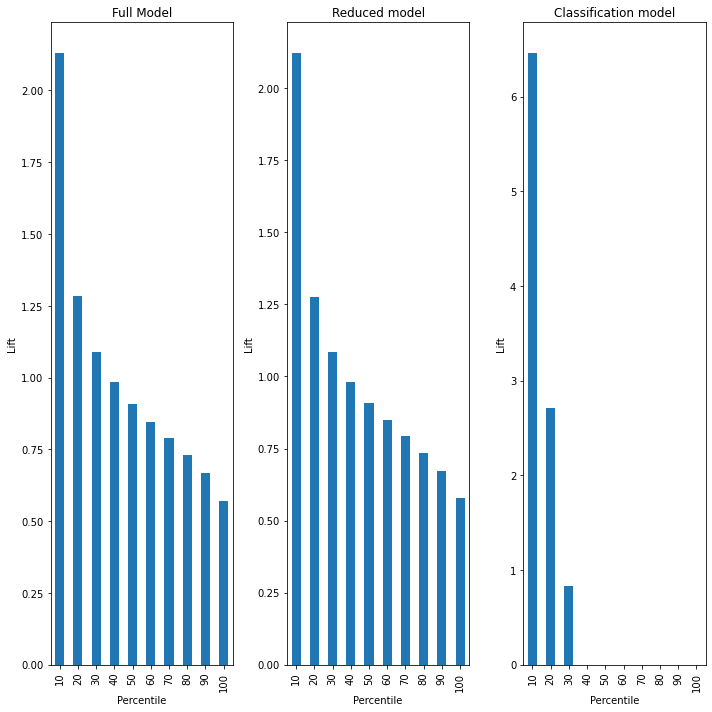

In [47]:

fig, axs = plt.subplots(1, 3, figsize = (10, 10))

liftChart(logit_result['p(1)'], title='Full Model', labelBars=False, ax=axs[0])
liftChart(newlogit_result['p(1)'], title='Reduced model', labelBars=False, ax=axs[1])
liftChart(fullClassTree_result['p(1)'], title='Classification model', labelBars=False, ax=axs[2])
ax.legend()
plt.tight_layout()
plt.show()


### ROC Curves & AUC

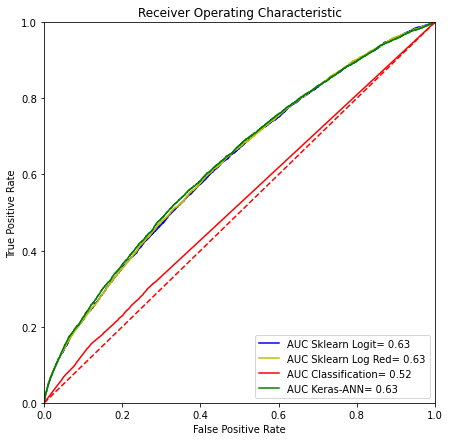

In [48]:
pred_y1 = logit.predict_proba(X_test)[:,1]  #Logistic Regression
pred_y2 = newlogit.predict_proba(X_test.drop(var_to_del, axis=1))[:,1] # Log Reg w/ Reduced variables
pred_y3 = fullClassTree.predict_proba(X_test)[:,1] # Classification Regression
pred_y4 = annmodel.predict(X_test_ann) # keras ANN

fpr1, tpr1, threshold1 = roc_curve(y_test,pred_y1)
fpr2, tpr2, threshold2 = roc_curve(y_test,pred_y2)
fpr3, tpr3, threshold3 = roc_curve(y_test,pred_y3)
fpr4, tpr4, threshold4 = roc_curve(y_test,pred_y4)

roc_auc1 = auc(fpr1, tpr1)
roc_auc2 = auc(fpr2, tpr2)
roc_auc3 = auc(fpr3, tpr3)
roc_auc4 = auc(fpr4, tpr4)

plt.figure(figsize=(7,7))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr1, tpr1, 'b', label = 'AUC Sklearn Logit= %0.2f' % roc_auc1)
plt.plot(fpr2, tpr2, 'y', label = 'AUC Sklearn Log Red= %0.2f' % roc_auc2)
plt.plot(fpr3, tpr3, 'r', label = 'AUC Classification= %0.2f' % roc_auc3)
plt.plot(fpr4, tpr4, 'g', label = 'AUC Keras-ANN= %0.2f' % roc_auc4)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()